## Подготовка

In [1]:
# Функция визуализации процесса сегментации изображений

def process_images(model,        # обученная модель
                   count=1     # количество случайных картинок для сегментации
                   ):

    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
    indexes = np.random.randint(0, len(x_val), count)

    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 15))

    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1, i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2, i].axis('off')

    plt.show()

In [2]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)

    return np.array(result)

In [6]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')):

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))

    # Вывод времени загрузки картинок выборки
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title,
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list))

    return image_list

### Подключение бибилиотек


In [3]:
# Callback ModelChekpoint для сохранения лучших весов модели
from tensorflow.keras.callbacks import ModelCheckpoint

# Основа для модели нейронной сети
from tensorflow.keras.models import Model

# Стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

# Дополнительные утилиты keras
from tensorflow.keras import utils

# Инструменты для построения графиков
import matplotlib.pyplot as plt

# Инструменты для работы с изображениями
from tensorflow.keras.preprocessing import image

# Инструменты для работы с массивами
import numpy as np

# Системные инструменты
import time
import random
import gdown
import os

# Дополнительные инструменты для работы с изображениями
from PIL import Image

# Дополнительные инструменты визуализации
import seaborn as sns
sns.set_style('darkgrid')

### Загрузка датасета


Зададим глобальные параметры:


In [4]:
# Глобальные параметры

IMG_WIDTH = 256               # Ширина картинки
IMG_HEIGHT = 256              # Высота картинки
CLASS_COUNT = 14           # Количество классов на изображении
# Название папки с файлами проверочной выборки
VAL_DIRECTORY = './dataset/val'
# Путь до папки, где сохраняются лучшие веса модели
checkpoint_filepath = './model.h5'

Загрузим входные изображения:


In [7]:
# Загрузка входных изображений
val_images = load_imageset(VAL_DIRECTORY, 'origa', 'Проверочная')

# Загрузка выходных (сегментированных) изображений
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Проверочная выборка загружена. Время загрузки: 2.91 с
Количество изображений: 100
Проверочная выборка загружена. Время загрузки: 0.77 с
Количество изображений: 100


In [9]:
background = (0, 0, 0)
back_bumper = (251, 233, 1)
back_glass = (26, 167, 55)
back_door = (0, 93, 173)
back_light = (230, 9, 42)

front_bumper = (74, 26, 128)
front_glass = (237, 89, 17)
front_door = (150, 195, 32)
front_light = (149, 17, 127)
hood = (245, 174, 8)

mirror = (9, 158, 162)
tailgate = (196, 255, 14)
trunk = (255, 174, 200)
wheel = (240, 240, 240)

Объединим все в один список меток классов:


In [10]:
CLASS_LABELS = (background, back_bumper, back_glass, back_door, back_light, front_bumper,
                front_glass, front_door, front_light, hood, mirror, tailgate, trunk, wheel)

### Формирование выборок


In [11]:
# Формирование проверочной выборки
x_val = []                            # Cписок под проверочную выборку
for img in val_images:                # Для всех изображений выборки:
    # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x = image.img_to_array(img)
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)

(100, 256, 256, 3)


### Создание модели для загрузки весов


In [14]:
from segmentation_models.metrics import IOUScore
metric = IOUScore()

Segmentation Models: using `keras` framework.


In [15]:
def masked_unet(class_count,  # количество классов
                input_shape   # форма входного изображения
                ):

    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D


    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_4_out)                                         # Добавляем слой MaxPooling2D


    ''' Block 5 '''
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv2')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv3')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_5_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_5_out


    ''' UP 1 '''
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_4_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(512, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation


    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[metric])

    # Возвращаем сформированную модель
    return model

## Распознавание


In [16]:
# Создание расширенной модели и вывод сводки

model_masked_unet = masked_unet(CLASS_COUNT,
                                (IMG_WIDTH, IMG_HEIGHT,3))

In [17]:
# Метод загрузки сохраненных весов из каталога
model_masked_unet.load_weights(checkpoint_filepath)

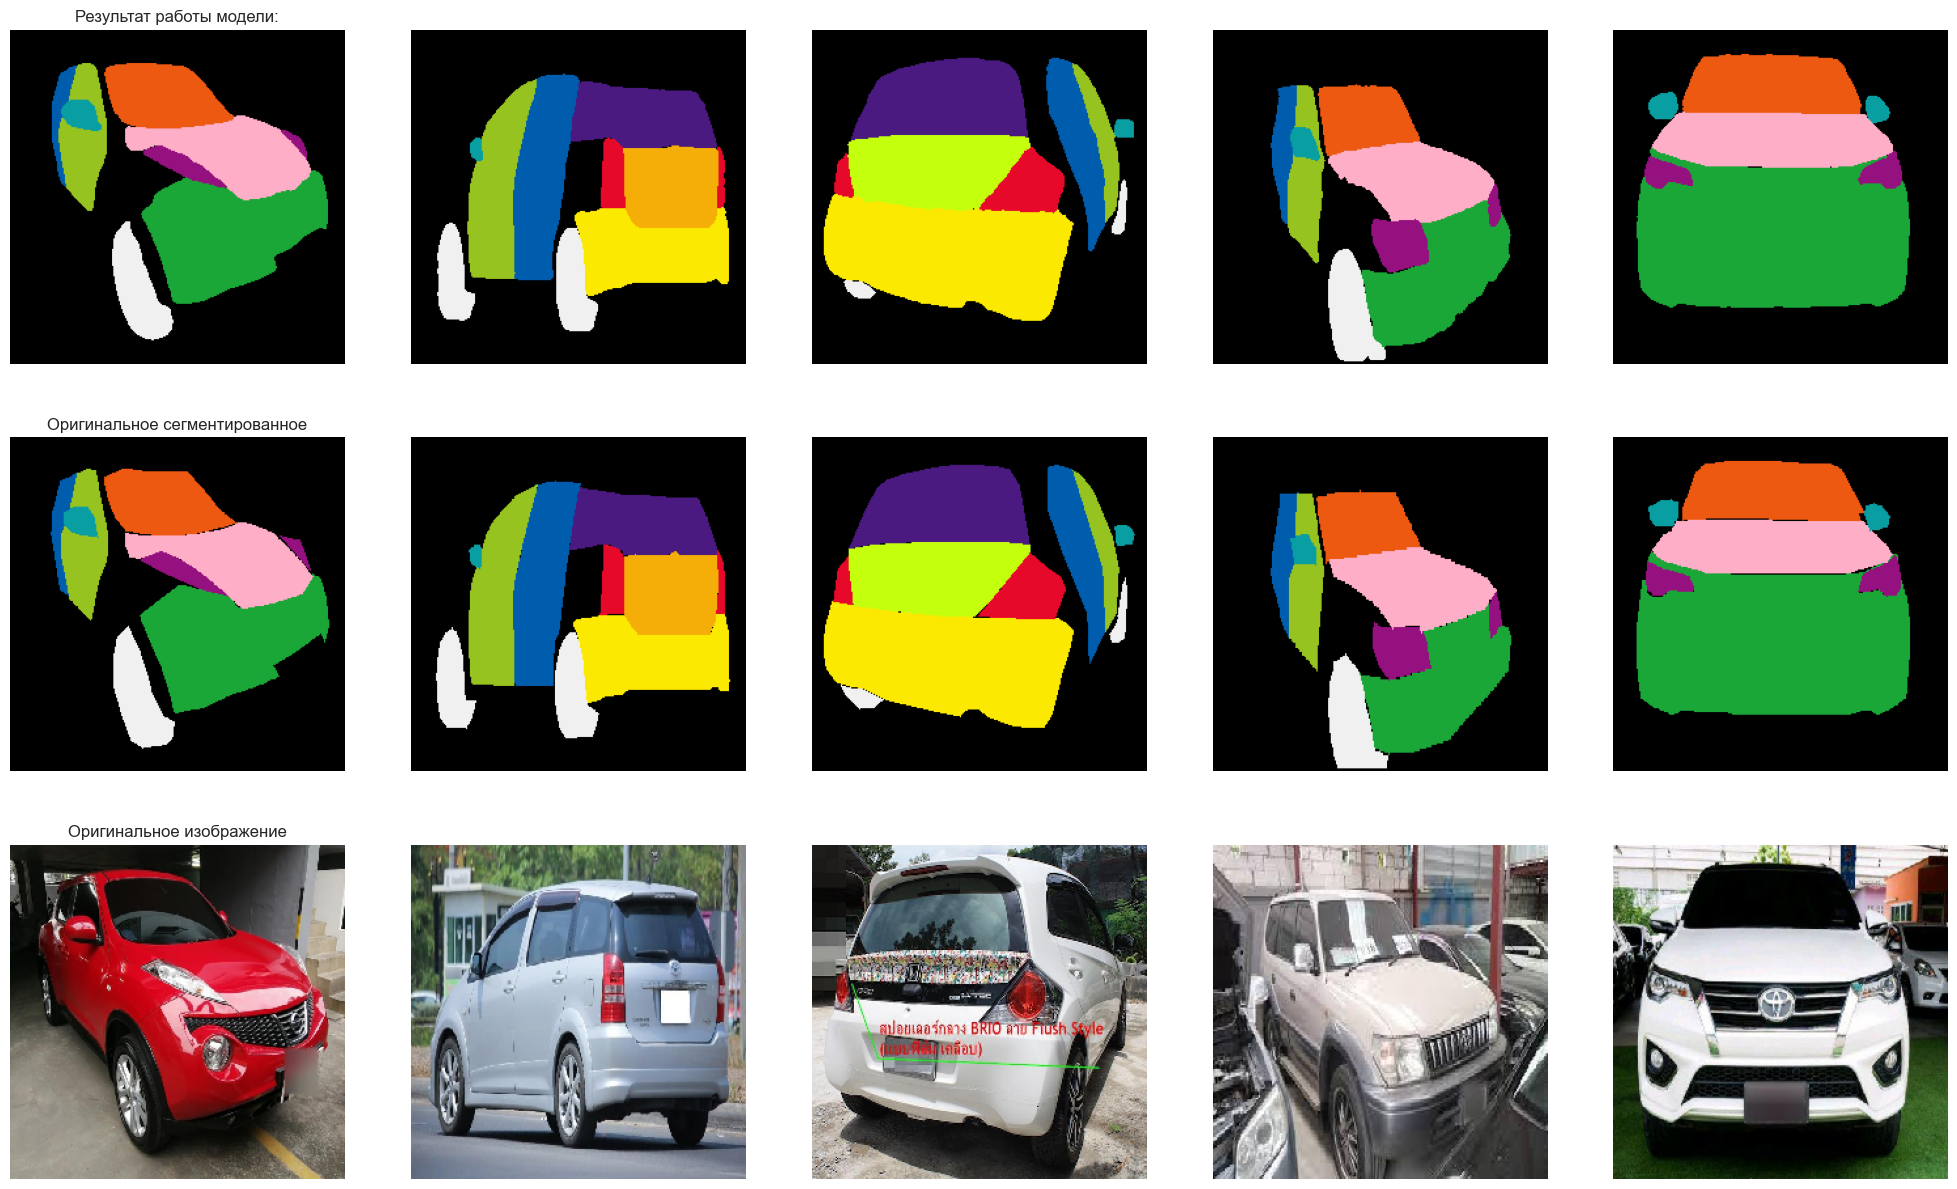

In [23]:
# Отображение результатов работы модели

process_images(model_masked_unet, 5)